In [13]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import json

#Defining plot style
plt.style.use('bmh')
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['lines.color'] = 'darkblue'


# Read the JSONLines file
file_path = r'..\Video Games playtime (How long to beat)\hltb.jsonlines'
games_playtime = pd.read_json(file_path, lines=True, encoding='utf-8')
games_playtime = (games_playtime
                    .astype({'Genres': 'category',})
                    .drop(columns=['steam_app_id','Review_score'])
                    .rename(columns={'Name':'name',
                                     'Release_date':'release_date'})
)


games_opencritic = pd.read_csv('..\Video Games playtime (How long to beat)\opencritic_rankings_feb_2023.csv', parse_dates=['release_date'])
games_opencritic["score"] = pd.to_numeric(games_opencritic["score"], errors='coerce')

games_opencritic = (games_opencritic
                    .astype({'score': 'Int8',
                             'opencritic_classification': 'category',
                             'platforms': 'category'})
                    .drop(columns=['url'])
                    .rename(columns={'title':'name'})
)



games_metacritic = pd.read_csv('..\Video Games playtime (How long to beat)\metacritic.csv',parse_dates=['release_date'],)
games_metacritic["user_review"] = pd.to_numeric(games_metacritic["user_review"], errors='coerce')

games_metacritic = (games_metacritic
                    .astype({'user_review':'float',
                             'platform':'category',
                             'meta_score': 'Int8',})
                    .drop(columns=['summary'])
                   )





In [14]:
games_playtime

,name,Stats,release_date,Genres
0,Borderlands 3,{'Additional Content': {'Moxxi's Heist of the ...,2019-09-13,"First-Person, Action, Shooter"
1,Dying Light,{'Additional Content': {'The Following': {'Pol...,2015-01-27,"Action, Adventure, Open World, Survival Horror"
2,Middle-Earth: Shadow of War,{'Additional Content': {'Blade of Galadriel': ...,2017-10-10,"Action, Adventure"
3,Counter-Strike: Global Offensive,"{'Multi-Player': {'Co-Op': {'Polled': '34', 'A...",2012-08-21,"First-Person, Shooter"
4,Grand Theft Auto IV,{'Additional Content': {'The Lost and Damned':...,2008-04-29,"Third-Person, Action, Sandbox, Shooter"
...,...,...,...,...
60404,Left-Hand Path,{'Platform': {}},2016-06-20,Adventure
60405,Astro Attack,{'Platform': {}},1984-00-00,"Scrolling, Shooter"
60406,Apocalypse: Party's Over,{'Single-Player': {'Main Story': {'Polled': '1...,2016-05-30,"Side, Scrolling, Action"
60407,10mg :),{'Single-Player': {'Main Story': {'Polled': '5...,2020-10-15,"Side, Top-Down, Real-Time, Arcade, Pinball, Pu..."


In [15]:
#Merge table to have all scores
games_table = ((games_playtime
               .merge(games_opencritic, how='left',on='name'))
               .merge(games_metacritic, how='left',on='name')) 

In [16]:
#Check which release date column is the most accurate 
(games_table['release_date_x'].isna().value_counts(), 
games_table['release_date'].isna().value_counts(), 
games_table['release_date_y'].isna().value_counts())

(release_date_x
 False    66010
 True         2
 Name: count, dtype: int64,
 release_date
 True     50862
 False    15150
 Name: count, dtype: int64,
 release_date_y
 True     55145
 False    10867
 Name: count, dtype: int64)

In [17]:
#Drop other realease date cols
games_table = (games_table
               .drop(columns=['release_date_y','release_date'])
               .rename(columns={'release_date_x':'release_date'}))



In [18]:
#Check difference of values in score columns (cuz we have metacritic and opencritic ones)
games_table["score"].isna().value_counts(), games_table["meta_score"].isna().value_counts()

(score
 True     58242
 False     7770
 Name: count, dtype: int64,
 meta_score
 True     50862
 False    15150
 Name: count, dtype: int64)

In [19]:
#Function to have scores for max games possible, opencritic score is more valued than metacritic one 
def append_score(df, col1, col2):
    for index, row in df.iterrows():
        if pd.isna(row[col1]) and not pd.isna(row[col2]):
            df.at[index, col1] = row[col2]
    return df
    
            

In [20]:
games_table = append_score(games_table,'score','meta_score')

In [21]:
#Checking value types for all cols --> Release_date is not in datetime and gives us error when using pd.to_datetime
games_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66012 entries, 0 to 66011
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   name                       66012 non-null  object  
 1   Stats                      66012 non-null  object  
 2   release_date               66010 non-null  object  
 3   Genres                     66012 non-null  category
 4   score                      17273 non-null  Int8    
 5   opencritic_classification  7770 non-null   category
 6   platforms                  10867 non-null  category
 7   platform                   15150 non-null  category
 8   meta_score                 15150 non-null  Int8    
 9   user_review                14114 non-null  float64 
dtypes: Int8(2), category(4), float64(1), object(3)
memory usage: 2.8+ MB


In [22]:
#Finding all rows with wrong date and correcting them
errors_date = []
for i in games_table.release_date.to_list():
    try:
        pd.to_datetime(i)
    except ValueError: 
        errors_date.append(i)

test_date = games_table.release_date.to_list()
new = []
for index, value in enumerate(test_date):
    if value:
        split = value.split('-') # split into year, month, day
        if (int(split[0])== 0):
            new.append(np.nan)
            pass
        else:
            for index2,value2 in enumerate(split):
                if int(value2) == 0 and (split.index(value2) in [1,2]) : #If the day is 00 or month or day is 00            
                    split[index2] = '01'                
            new_text = '-'.join(split)
            new.append(new_text)
    else:
        new.append(np.nan)


games_table['release_date'] =  pd.to_datetime(new)

In [23]:
#Removing all DLC and multiplayer games to focus on single player ones and have a "smaller" table
def remove_entries(stats_dict):
    if isinstance(stats_dict, str):
        stats_dict = json.loads(stats_dict)
    
    # Use dict.pop() to remove entries, which is more efficient
    stats_dict.pop("Additional Content", None)
    
    multi_player = stats_dict.get("Multi-Player", {})
    multi_player.pop("Competitive", None)
    
    # If Multi-Player is empty, remove it
    if not multi_player:
        stats_dict.pop("Multi-Player", None)
    
    return stats_dict


# Apply the function to the 'stats' column
games_table['Stats'] = games_table['Stats'].apply(remove_entries)

In [24]:
#Function to extract genres, flows and perspectives from Genres column, to have a better way of classifying games. Based on most popular genre, flows 
# and perspectives listed on Howlongtobeat.com
def categorize_genres(df):
    # Define the categories
    perspectives = ['First-Person', 'Isometric', 'Side', 'Text', 'Third-Person', 'Top-Down', 'Virtual Reality']
    flows = ['Incremental','Massively Multiplayer', 'Multidirectional', 'On-Rails', 'Point-and-click', 'Real-Time', 'Scrolling', 'Turn-Based']
    genres = [
        'Action', 'Adventure', 'Arcade', 'Battle Arena', 'Beat em Up', 'Board Game', 
        'Breakout', 'Card Game', 'City-Building', 'Compilation', 'Educational',
        'Fighting', 'Fitness', 'Flight', 'Full Motion Video', 'Hack and Slash',
        'Hidden Object', 'Horror', 'Interactive Art', 'Management',
        'Music/Rhythm', 'Open World', 'Party', 'Pinball', 
        'Platform', 'Puzzle', 'Racing/Driving', 'Roguelike',
        'Role-Playing', 'Sandbox', 'Shooter', 
        'Simulation', 'Social', 'Sports',
        'Stealth', 'Strategy/Tactical',
        'Survival', 'Tower Defense',
        'Trivia', 
        'Visual Novel','Vehicular Combat'
    ]

    # Initialize new columns with empty strings
    df['Perspectives'] = ''
    df['Flows'] = ''
    df['Genre'] = ''

    # Function to extract matching values for each category
    def extract_values(genre_list, category):
        return ', '.join([item for item in genre_list if item in category])

    # Process each row
    for index, row in df.iterrows():
        if pd.notna(row['Genres']):  # Check if Genres is not NaN
            genre_list = [g.strip() for g in row['Genres'].split(',')]  # Split and clean the Genres column
            df.at[index, 'Perspectives'] = extract_values(genre_list, perspectives)
            df.at[index, 'Flows'] = extract_values(genre_list, flows)
            df.at[index, 'Genre'] = extract_values(genre_list, genres)
    df = df.drop(columns='Genres')
    return df




In [25]:
#Applying function and getting rid of useless columns
games_table = categorize_genres(games_table)
games_table = games_table.drop(columns=['platforms','meta_score'])

In [26]:
#Dates are now in the right format and we only have the necessary columns. This table will be our "base".
games_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66012 entries, 0 to 66011
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       66012 non-null  object        
 1   Stats                      66012 non-null  object        
 2   release_date               62877 non-null  datetime64[ns]
 3   score                      17273 non-null  Int8          
 4   opencritic_classification  7770 non-null   category      
 5   platform                   15150 non-null  category      
 6   user_review                14114 non-null  float64       
 7   Perspectives               66012 non-null  object        
 8   Flows                      66012 non-null  object        
 9   Genre                      66012 non-null  object        
dtypes: Int8(1), category(2), datetime64[ns](1), float64(1), object(5)
memory usage: 3.8+ MB


In [27]:
games_table.head(4)

,name,Stats,release_date,score,opencritic_classification,platform,user_review,Perspectives,Flows,Genre
0,Borderlands 3,{'Single-Player': {'Main Story': {'Polled': '4...,2019-09-13,81,Strong,Xbox One,5.5,First-Person,,"Action, Shooter"
1,Borderlands 3,{'Single-Player': {'Main Story': {'Polled': '4...,2019-09-13,81,Strong,PC,5.3,First-Person,,"Action, Shooter"
2,Borderlands 3,{'Single-Player': {'Main Story': {'Polled': '4...,2019-09-13,81,Strong,PlayStation 4,5.9,First-Person,,"Action, Shooter"
3,Dying Light,{'Single-Player': {'Main Story': {'Polled': '7...,2015-01-27,74,Fair,PC,8.0,,,"Action, Adventure, Open World"


In [28]:
#Function to get rid of the "K" in polled stats and turn 1.5K into 1500 for example.
def convert_polled(value_to_conv):
        if not value_to_conv:
            return 0

        if pd.isna(value_to_conv):
            return 0
        
        if value_to_conv[-1] == 'K':
            new_string = value_to_conv[:-1]
            number = float(new_string) * 1000
        else:
            number = float(value_to_conv)
            
        return number

def convert_polled_columns(df):

    # Iterate over all columns 
    for col in df.columns:
        if "polled" not in col.lower():
            continue

        df[col] = df[col].apply(convert_polled)

    return df

In [29]:
#Converting completion time stats from strings "23h50min" to full float hours to be usable
def convert_timedelta_to_hours(df):
    
    # Iterate over all columns starting from the specified column
    for col in df.columns:
        # Skip columns with "polled" or "name" in the name 
        if "polled" in col.lower() or "name" in col.lower():
            continue
        
        # Function to convert a single value to minutes
        def convert_value_to_hours(val):
            if pd.isna(val):
                return np.nan
            try:
                # Replace 'h' with 'hours ' and 'm' with 'minutes'
                val_str = str(val).replace('h', 'hours ').replace('m', 'minutes')
                # Convert to timedelta
                td = pd.to_timedelta(val_str)
                # Convert timedelta to total minutes
                return int(td.total_seconds() / 3600)
            except:
                return np.nan  # Return NaN if conversion fails
        
        # Apply the conversion function to the column
        df[col] = df[col].apply(convert_value_to_hours)
    
    return df

In [30]:
#Function to extract and classify all Stats and put them in new columns
def extract_and_create_df(df, dict_entry):
    def extract_stats(data):
        stats = {}
        for category, category_data in data.get(dict_entry, {}).items():
            if isinstance(category_data, dict):
                stats.update({
                    f'{dict_entry.lower()}_{category.lower().replace(" ", "_")}_{stat.lower()}': value
                    for stat, value in category_data.items()
                })
        return stats

    # Extract stats using a vectorized operation
    extracted_stats = df['Stats'].apply(extract_stats)

    # Create a new DataFrame with the extracted stats
    stats_df = pd.DataFrame.from_records(extracted_stats, index=df.index)

    
    # Add the 'Name' column and reorder columns
    stats_df['name'] = df['name']
    stats_df = stats_df[['name'] + [col for col in stats_df.columns if col != 'name']]

    stats_df = convert_polled_columns(stats_df)
    stats_df = convert_timedelta_to_hours(stats_df)
    stats_df = stats_df.drop_duplicates(subset='name')
    stats_df = stats_df.reset_index(drop=True)
    
    return stats_df




In [31]:
#Function to extract and classify all Stats and put them in new columns for each paltform
def create_platform_df_from_stats(df, platform):
    def extract_platform_data(stats_dict):
        return stats_dict.get('Platform', {}).get(platform)

    # Extract platform data and create a mask for valid rows
    platform_data = df['Stats'].apply(extract_platform_data)
    valid_mask = platform_data.notna()

    # Check if any valid data exists
    if not valid_mask.any():
        # Return an empty DataFrame with just the 'name' column if no data found
        return pd.DataFrame({'name': df['name']})

    # Create a new DataFrame with the extracted data
    platform_df = pd.DataFrame.from_records(
        platform_data[valid_mask].tolist(),
        index=df.index[valid_mask]
    )

    # Add the 'Name' column
    platform_df['name'] = df.loc[valid_mask, 'name']

    # Add platform name to each column except 'Name'
    platform_df.columns = ['name' if col == 'name' else f'{platform}_{col}' for col in platform_df.columns]

    # Reorder columns to put 'Name' first
    platform_df = platform_df[['name'] + [col for col in platform_df.columns if col != 'name']]
    platform_df = convert_polled_columns(platform_df)
    platform_df = convert_timedelta_to_hours(platform_df)
    platform_df = platform_df.reset_index(drop=True)
    platform_df['platform'] = platform
    platform_df = platform_df[platform_df[f"{platform}_Polled"] >= 20]
    platform_df = platform_df.drop_duplicates(subset='name')
    return platform_df


In [32]:
#Creating all useful tables (we reduced platforms to the most popular ones, listed by Howlongtobeat.com)
sp_games = extract_and_create_df(games_table,'Single-Player')
mp_games = extract_and_create_df(games_table,'Multi-Player')
pc_games = create_platform_df_from_stats(games_table, 'PC')
ps3_games = create_platform_df_from_stats(games_table, 'PlayStation 3')
ps4_games = create_platform_df_from_stats(games_table, 'PlayStation 4')
ps5_games = create_platform_df_from_stats(games_table, 'PlayStation 5')
psnow_games = create_platform_df_from_stats(games_table, 'PlayStation Now')
x360_games = create_platform_df_from_stats(games_table, 'Xbox 360')
xone_games = create_platform_df_from_stats(games_table, 'Xbox One')
xsxs_games = create_platform_df_from_stats(games_table, 'Xbox Series X/S')
n3ds_games = create_platform_df_from_stats(games_table, 'Nintendo 3DS')
nswitch_games = create_platform_df_from_stats(games_table, 'Nintendo Switch')
wiiu_games = create_platform_df_from_stats(games_table, 'Wii U')
emulated_games = create_platform_df_from_stats(games_table, 'Emulated')

In [33]:
#Function Renaming columns fo easier use and cleaner table
def rename_columns(table,old_word, new_word):
    table.columns = table.columns.str.replace(old_word,new_word)
    return table

In [34]:
sp_games = rename_columns(sp_games,'single-player', "sp")
mp_games = rename_columns(mp_games,'multi-player', "mp")


In [35]:
#Limiting tables only to games with +20 people polled to be representative. 
sp_games = sp_games[sp_games["sp_all_playstyles_polled"] >= 20]
mp_games = mp_games[mp_games["mp_co-op_polled"] >= 20]

#Cleaning empty rows
sp_games = sp_games.dropna(subset=["sp_main_story_average"]).reset_index(drop=True)
mp_games = mp_games.dropna(subset=["mp_co-op_average"]).reset_index(drop=True)

#Merging sp_games to have genres and release dates
sp_games = sp_games.merge(games_table[['name','release_date','Perspectives','Flows','Genre']],how='left', on='name')
sp_games = sp_games.drop_duplicates(subset='name')

#Dropping all game types that are not single player. They will have very high gametimes that will "fausser" values 
sp_games = sp_games[~sp_games['Genre'].str.contains('Battle Arena|Music/Rhythm')]
sp_games = sp_games[~sp_games['Flows'].str.contains('Massively Multiplayer|Incremental')]


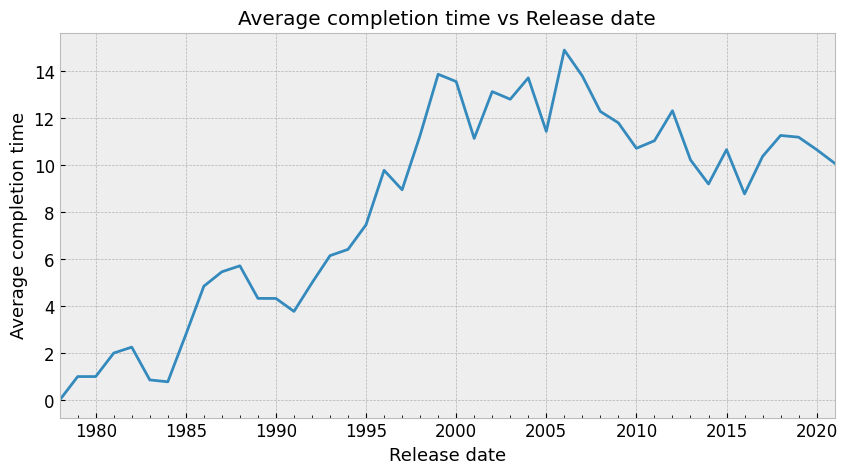

In [36]:
new_sp_games = sp_games.dropna(subset=["sp_main_story_average"]).reset_index(drop=True)
new_sp_games = new_sp_games.set_index('release_date').sort_index()
new_sp_games['sp_main_story_average'].resample('YE').mean().loc[:'2021'].plot(figsize=(10,5))

plt.xlabel('Release date', fontsize=13)
plt.title('Average completion time vs Release date')
plt.ylabel('Average completion time', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("Average completion time vs Release date")
plt.show()



In [37]:
#Function to group games by game lenght groups.
def game_lenght_groups(df,col_to_group,col_to_sum,aggregation):
    bins = np.arange(0, df[col_to_group].max() + 5, 5)
    labels = [f'{int(bins[i])}-{int(bins[i+1])} hours' for i in range(len(bins)-1)]
    
    # Group sp_main_story_average into bins
    df[f"{col_to_group}_group"] = pd.cut(df[col_to_group], bins=bins, labels=labels, right=False)
    
    # Sum sp_main_story_polled for each group
    result = df.groupby(f"{col_to_group}_group", observed=False)[col_to_sum].agg(aggregation)
    return result


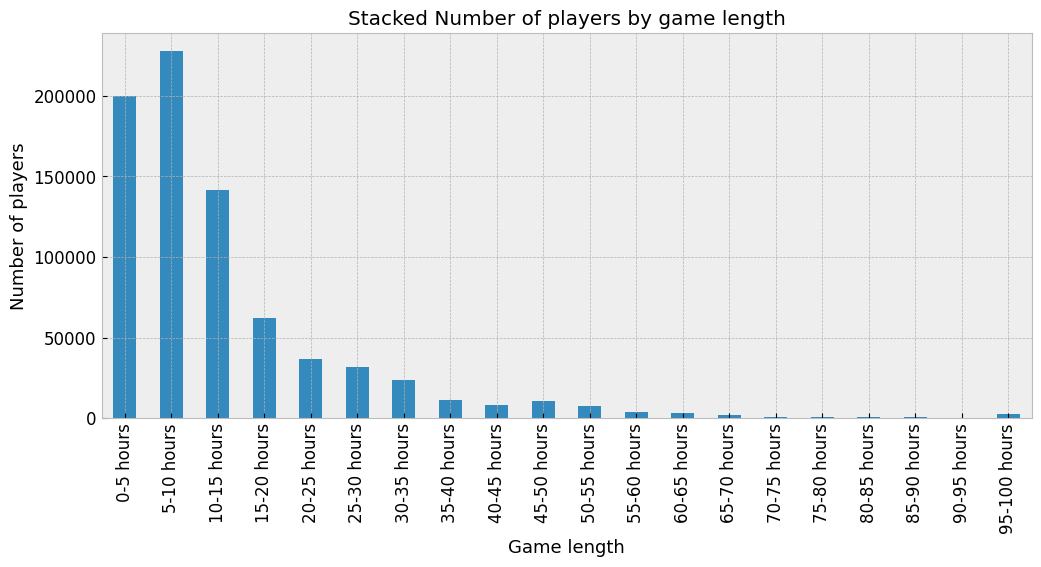

In [38]:
new = game_lenght_groups(sp_games, 'sp_main_story_average', 'sp_main_story_polled','sum')
new.head(20).plot.bar(figsize=(12,5))

plt.xlabel('Game length', fontsize=13)
plt.ylabel('Number of players', fontsize=13)
plt.title('Stacked Number of players by game length')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("Stacked Number of players by game lenght.png", bbox_inches='tight')

plt.show()

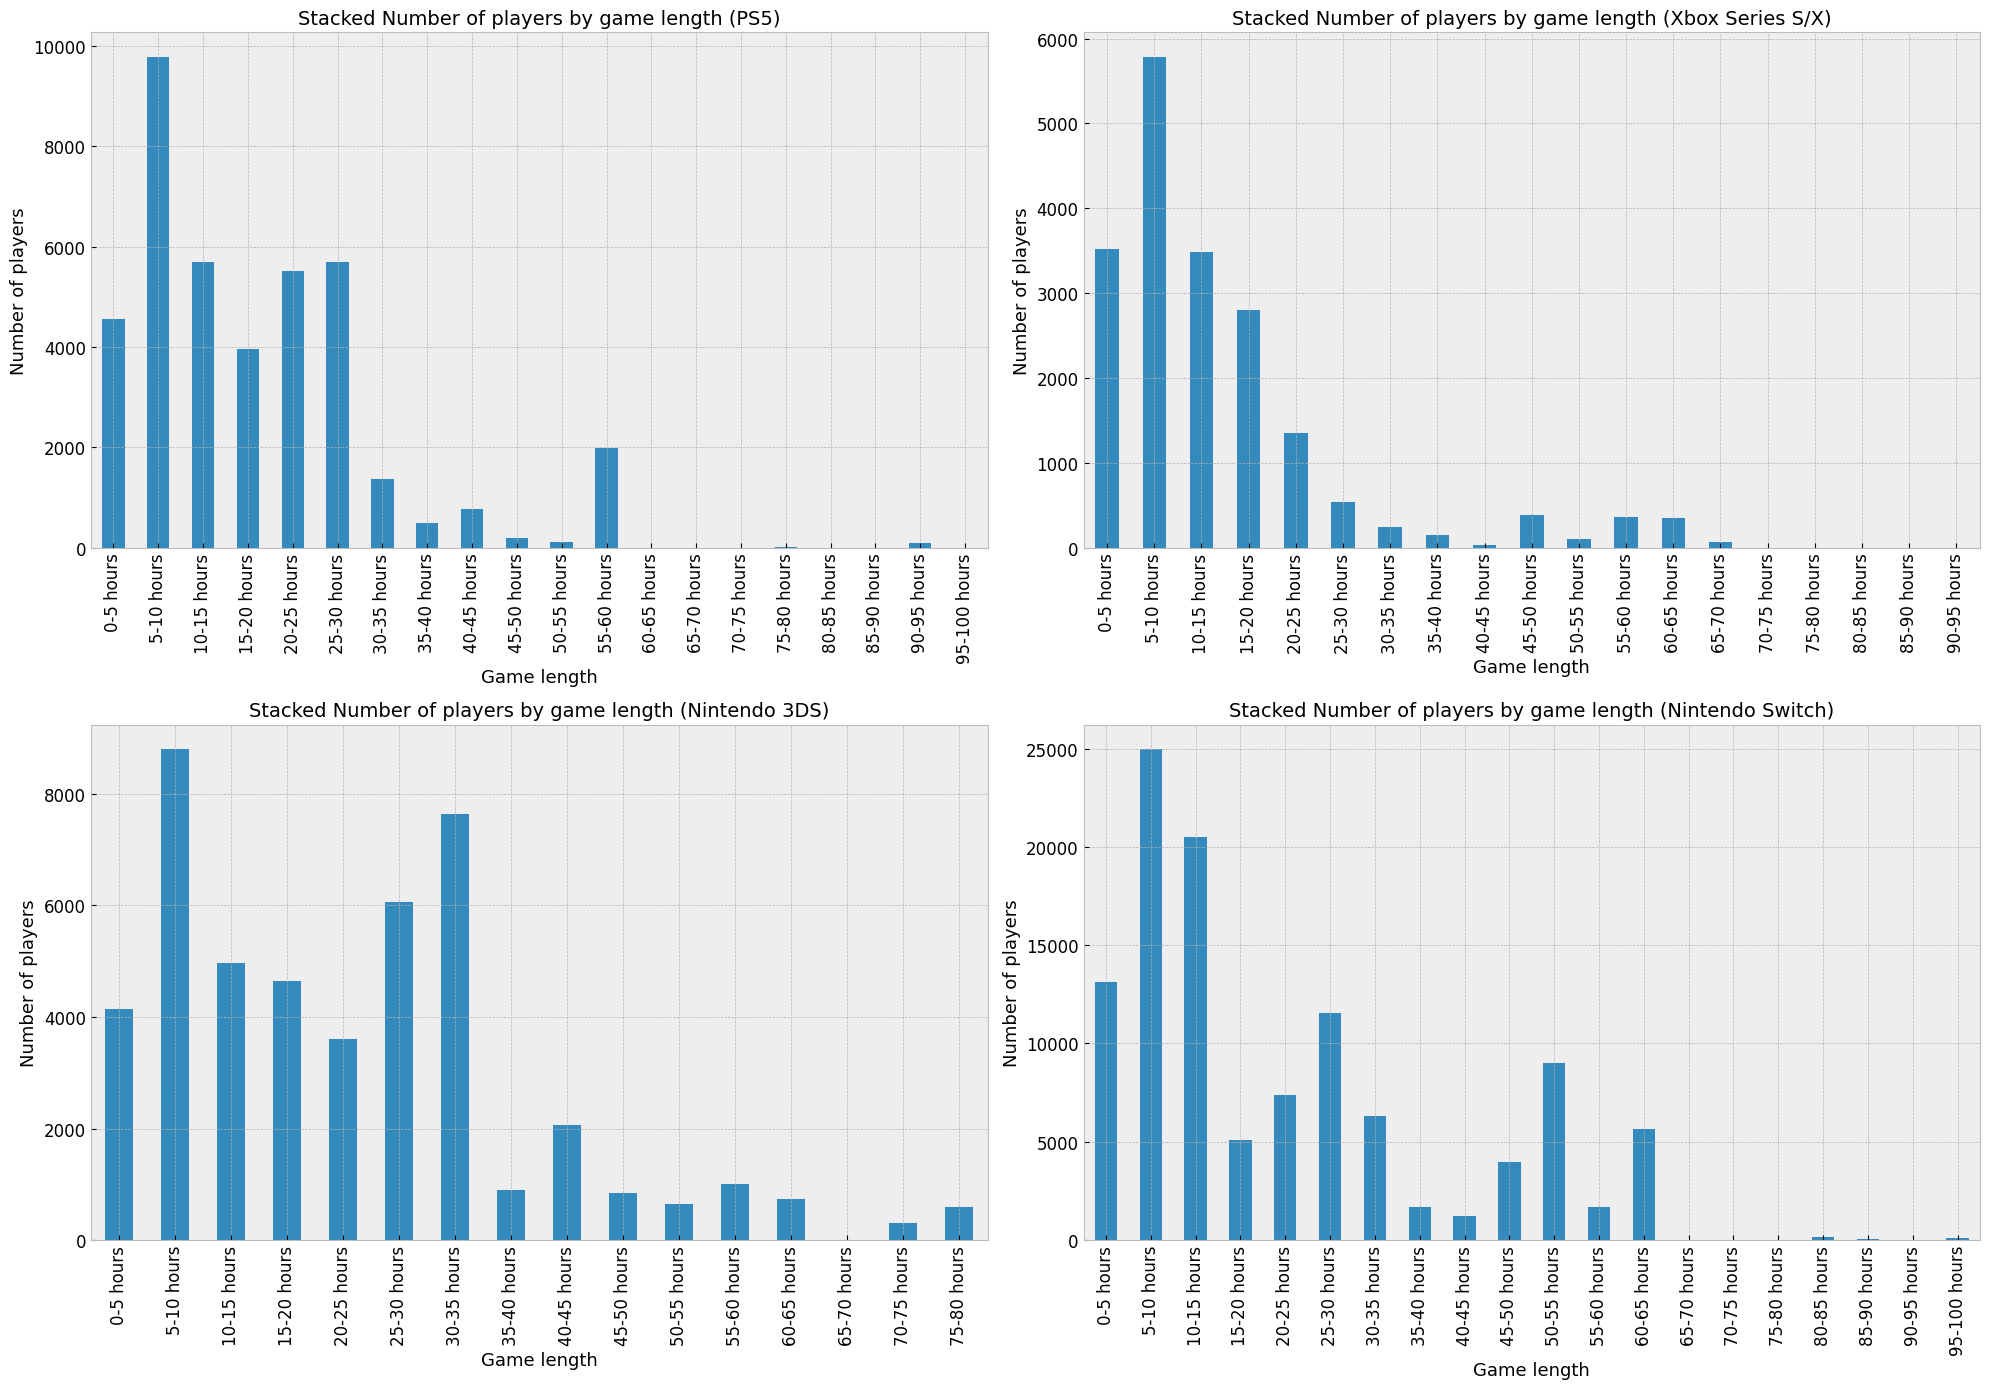

In [39]:

# Create the data for all four graphs
new1 = game_lenght_groups(ps5_games, 'PlayStation 5_Main', 'PlayStation 5_Polled','sum')
new2 = game_lenght_groups(xsxs_games, 'Xbox Series X/S_Main', 'Xbox Series X/S_Polled','sum')
new3 = game_lenght_groups(n3ds_games, 'Nintendo 3DS_Main', 'Nintendo 3DS_Polled','sum')
new4 = game_lenght_groups(nswitch_games, 'Nintendo Switch_Main', 'Nintendo Switch_Polled','sum')

# Create subplots with shared X and Y axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14))

# Plot the graphs
new1.head(20).plot.bar(ax=ax1)
new2.head(20).plot.bar(ax=ax2)
new3.head(20).plot.bar(ax=ax3)
new4.head(20).plot.bar(ax=ax4)

# Set titles, xlabels, and ylabels
for ax, title in zip([ax1, ax2, ax3, ax4], 
                     ['PS5', 'Xbox Series S/X', 'Nintendo 3DS', 'Nintendo Switch']):
    ax.set_title(f'Stacked Number of players by game length ({title})', fontsize=14)
    ax.set_xlabel('Game length', fontsize=13)
    ax.set_ylabel('Number of players', fontsize=13)
    ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig("Stacked Number of players by game lenght for consoles", bbox_inches='tight')
plt.show()


In [40]:
#Function to merge all popular platform tables and get only values for one specific column
def merge_cols_with_platforms(col_to_merge):
    platform_list = ['ps3', 'ps4', 'ps5','pc','x360','xone','xsxs','n3ds','nswitch','wiiu']
    df_list = []
    for platform_short in platform_list:
        platform_df = globals()[f"{platform_short}_games"]
        platform_full = platform_df['platform'].iloc[0]  # Get the full platform name from the first row
        
        df = (sp_games[['name']]
              .merge(platform_df[['name', f'{platform_full}_{col_to_merge}', 'platform']], 
                     how='left', on='name')
              .rename(columns={f'{platform_full}_{col_to_merge}': f'{col_to_merge}_average'}))
        df_list.append(df)

    final = pd.concat(df_list, ignore_index=True)
    return final


In [41]:
table = merge_cols_with_platforms('Main')
table = table.dropna(subset='Main_average')
table

,name,Main_average,platform
3,Grand Theft Auto IV,28.0,PlayStation 3
6,Borderlands: The Pre-Sequel!,21.0,PlayStation 3
8,Half-Life 2: Episode One,4.0,PlayStation 3
10,Limbo,3.0,PlayStation 3
18,Far Cry 3,15.0,PlayStation 3
...,...,...,...
77985,Mario Kart 8 - Animal Crossing DLC,0.0,Wii U
78280,Devil's Third,8.0,Wii U
78435,FAST Racing Neo,3.0,Wii U
78462,Tekken Tag Tournament 2: Wii U Edition,0.0,Wii U


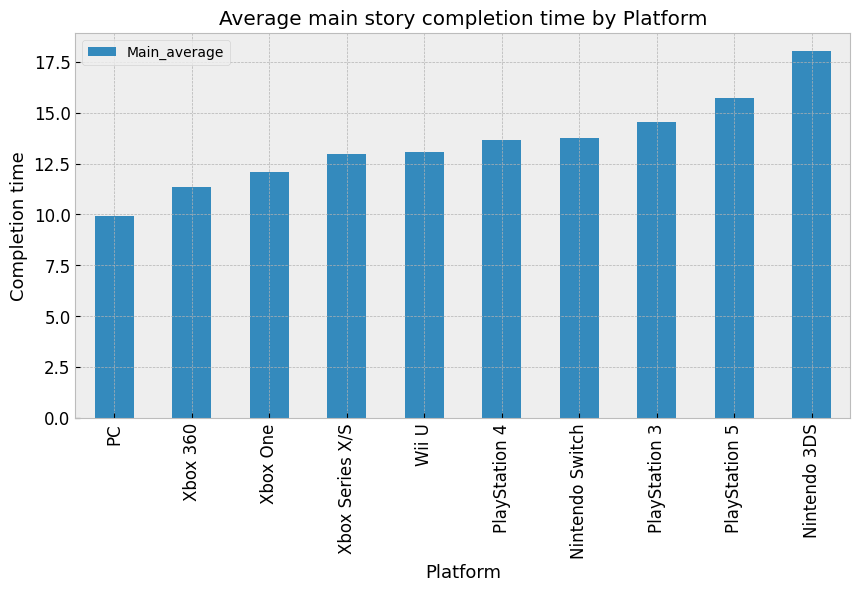

In [42]:

(table
    .groupby(['platform'])[['Main_average']]
    .mean()
    .sort_values(by='Main_average',ascending=True)
    .plot.bar(figsize=(10,5), title = "Average main story completion time by Platform" ))


plt.xlabel('Platform', fontsize=13)
plt.ylabel('Completion time', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("Avg Main Story completion time by Platform", bbox_inches='tight')
plt.show()

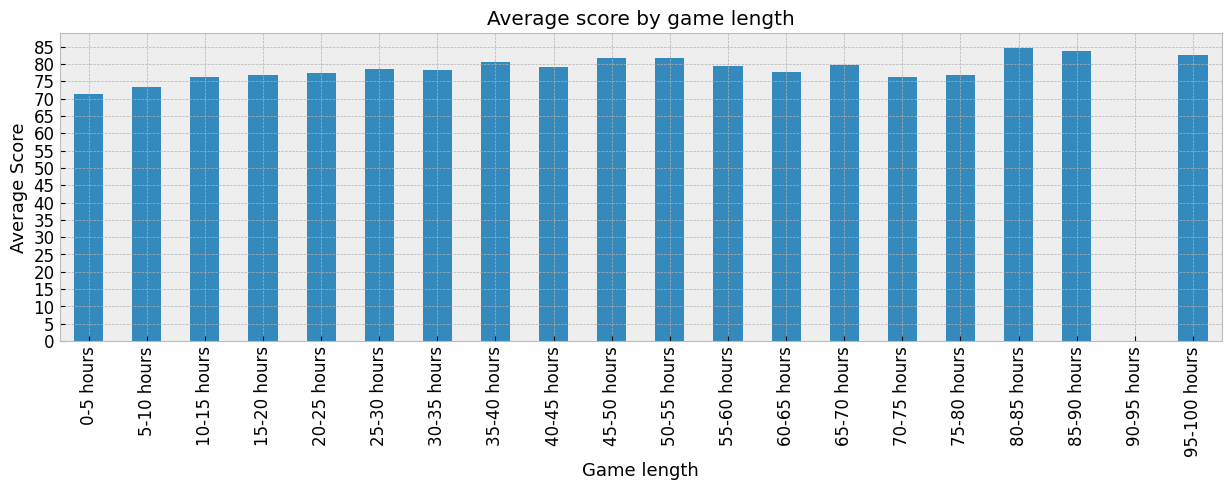

In [43]:
new = sp_games.merge(games_table[['name','score']], how='inner',on='name').dropna(subset='score')
new2 = game_lenght_groups(new, 'sp_main_story_average', 'score','mean')

new2.head(20).plot.bar(figsize=(15,4))
plt.yticks(np.arange(0,90,5))
plt.xlabel('Game length', fontsize=13)
plt.ylabel('Average Score', fontsize=13)
plt.title('Average score by game length')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("Average score by game lenght", bbox_inches='tight')
plt.show()

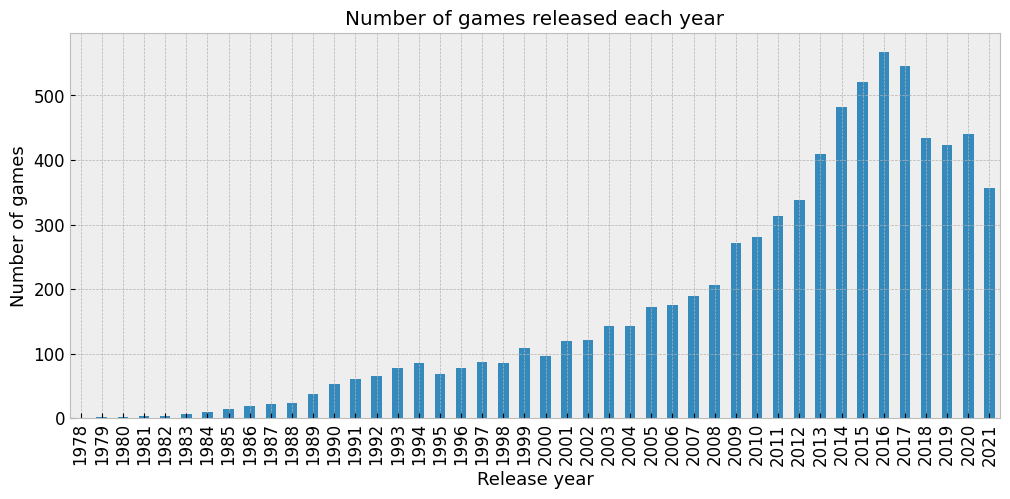

In [44]:

# Create the bar plot
ax = new_sp_games['name'].resample('YE').count().loc[:'2021'].plot.bar(figsize=(12,5))

# Set x-ticks to display only the year
plt.xticks(range(len(ax.get_xticklabels())), 
           [label.get_text()[:4] for label in ax.get_xticklabels()], 
           rotation=90)

plt.xlabel('Release year', fontsize=13)
plt.ylabel('Number of games', fontsize=13)
plt.title('Number of games released each year')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("Number of games released each year", bbox_inches='tight')
plt.show()


In [45]:
#Creating a table gathering player polled values for all popular platforms with genres, perspectives and flows.
table_Polled = merge_cols_with_platforms('Polled')
table_Polled = table_Polled.dropna(subset='Polled_average')
table_Polled_full = table_Polled.merge(games_table[['name','Perspectives','Flows','Genre']], how = 'left', on='name').drop_duplicates()
table_Polled_full.head(2)

,name,Polled_average,platform,Perspectives,Flows,Genre
0,Grand Theft Auto IV,360.0,PlayStation 3,Third-Person,,"Action, Sandbox, Shooter"
3,Borderlands: The Pre-Sequel!,26.0,PlayStation 3,First-Person,,"Action, Role-Playing, Shooter"


In [46]:
#Function to operate an aggregation for every genre for specific value and grouped by specific column
def create_genres_count(df, genre_list, value_to_group, col_to_group_on, aggregation):
    genres_count = pd.DataFrame()  # Initialize an empty DataFrame
    
    for item in genre_list:
        # Filter rows where 'Genre' contains the genre and count occurrences by year
        genre_counts = (df[df['Genre'].str.contains(item, na=False, case=False)]
                        .groupby(col_to_group_on)[value_to_group]
                        .agg(aggregation)
                        .to_frame(name=item)
                        .reset_index())
        
        # Merge the counts into the main DataFrame
        if genres_count.empty:
            genres_count = genre_counts  # Initialize with the first genre's counts
        else:
            genres_count = genres_count.merge(genre_counts, on=col_to_group_on, how='outer')
    
    # Set the specified column as the index
    genres_count = genres_count.set_index(col_to_group_on)
    
    return genres_count




In [47]:
genre_list = ['Shooter', 'Action, Adventure', 'Role-Playing', 'Simulation', 'Sports', 'Puzzle', 'Open World', 'Platform']
new = create_genres_count(table_Polled_full, genre_list, 'Polled_average', 'platform', 'sum')
new.head(2)

,Shooter,"Action, Adventure",Role-Playing,Simulation,Sports,Puzzle,Open World,Platform
platform,,,,,,,,
Nintendo 3DS,602.0,7895.0,19859.0,900.0,217.0,4047.0,270.0,5751.0
Nintendo Switch,2892.0,22399.0,38504.0,2308.0,1211.0,4754.0,9821.0,29523.0


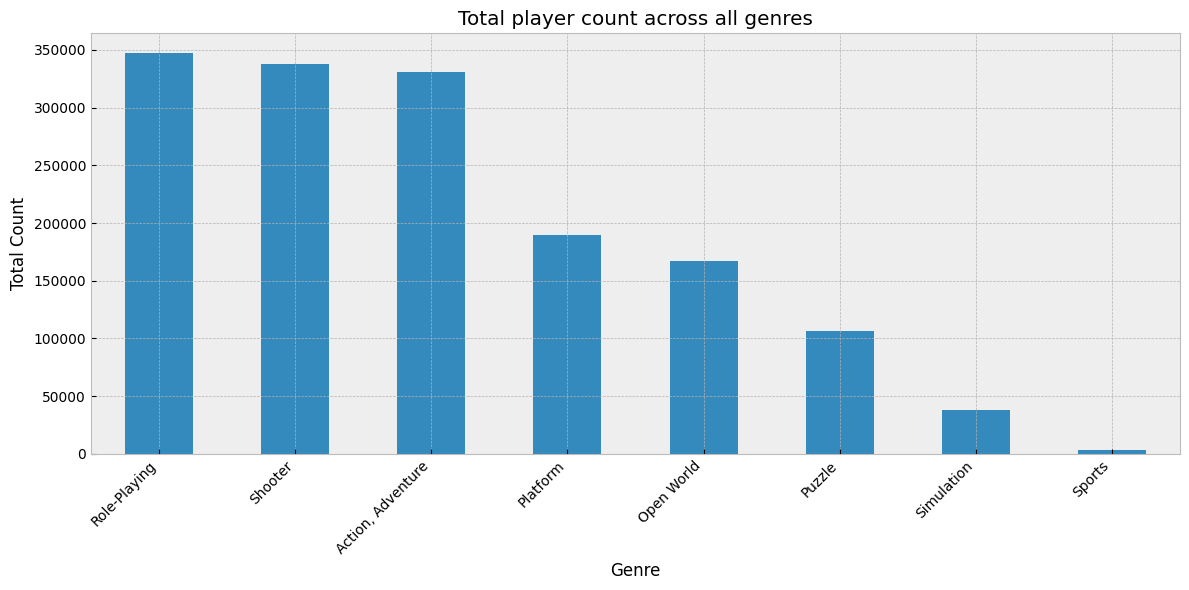

In [48]:
#Calculating total player count across all genres.

# Calculate the sum of each column
total_row = new.sum(numeric_only=True)

# Add the total row to the DataFrame
new.loc['Total'] = total_row

# Extract the 'Total' row
total_row = new.loc['Total']

# Plot the 'Total' row as a bar chart
total_row.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))

plt.title('Total player count across all genres')
plt.xlabel('Genre')
plt.ylabel('Total Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("Total Counts Across All Genres", bbox_inches='tight')
plt.show()


In [49]:
#Creating a clean score table from base table by dropping all games with no score
games_table_score = games_table.dropna(subset='score').dropna(subset='platform')

In [50]:
#Function to filter the table only for the popular platforms
def cut_unpopular_platforms(df):
    popular_list = [
        'Emulated','Nintendo 3DS','3DS', 
        'Nintendo Switch','Switch', 'PC', 
        'PlayStation 3', 'PlayStation 4', 
        'PlayStation 5', 'Wii U', 'Xbox 360', 
        'Xbox One', 'Xbox Series X/S','Xbox Series X','PlayStation 2',]
    
    def is_popular(platform):
        if pd.isna(platform):
            return False
        return any(pop.lower() in platform.lower() for pop in popular_list)
    
    # Filter the DataFrame
    df = df[df['platform'].apply(is_popular)]
    
    return df

games_table_score = cut_unpopular_platforms(games_table_score)

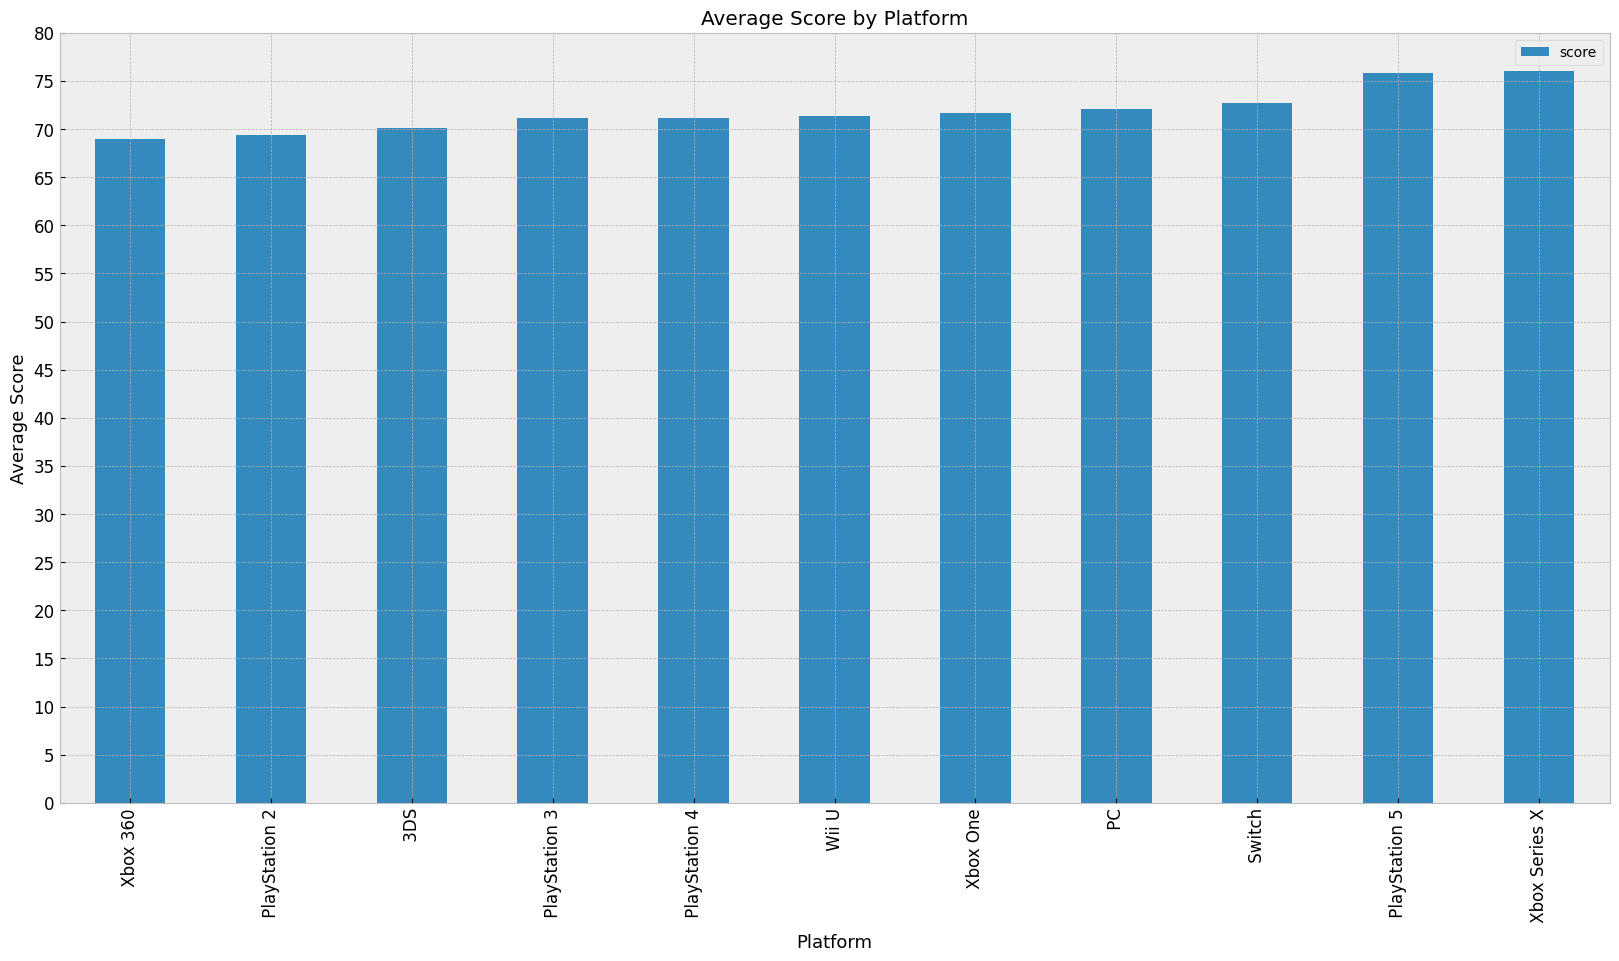

In [51]:

(games_table_score[['name','score','platform']]
 .groupby(['platform'], observed = False)[['score']]
 .mean()
 .sort_values(by='score',ascending=True)
 .dropna()
 .plot
 .bar(figsize=(20,10), title = "Average Score by Platform" ))

plt.yticks(np.arange(0, 85, 5))
plt.xlabel('Platform', fontsize=13)
plt.ylabel('Average Score', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("Average score vs Platform", bbox_inches='tight')
plt.show()

In [52]:
#Creating an accurate table for Genres, with no missing values and a year index.

# Create an explicit copy after filtering
games_table_full = games_table[games_table['Genre'] != ''].copy()

# Perform operations on the copy
games_table_full.dropna(subset='release_date', inplace=True)
games_table_full["year"] = games_table_full["release_date"].dt.year
#games_table_full["year"] = games_table_full["year"].astype('string')
# Set index and sort
games_table_full = games_table_full.set_index('year').sort_index()


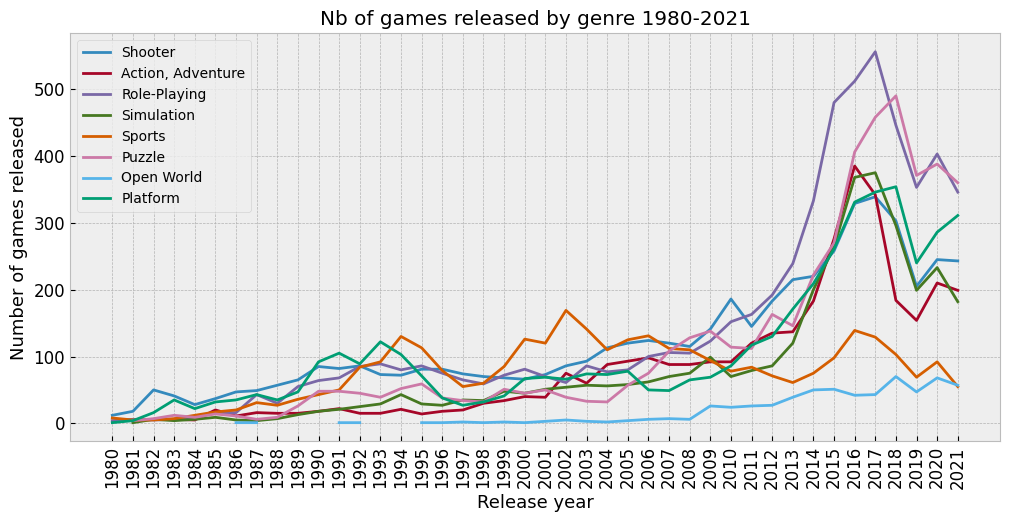

In [53]:
#Plotting for popular platforms listed by Howlongtobeat.com
genre_list = ['Shooter', 'Action, Adventure', 'Role-Playing', 'Simulation', 'Sports', 'Puzzle', 'Open World', 'Platform']
create_genres_count(games_table_full, genre_list, 'name', 'year', 'count').sort_index().loc["1980":"2021"].plot(figsize=(12, 6),title='Nb of games released by genre 1980-2021')


plt.xticks(np.arange(1980, 2022, 1), rotation=90)
plt.xlabel('Release year', fontsize=13)
plt.ylabel('Number of games released', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.subplots_adjust(bottom=0.2)
plt.savefig("Number of games released by Genre 1980-2021", bbox_inches='tight')
plt.show()


In [54]:
(table_Polled_full[['name','Polled_average','Genre']]
 .sort_values(by='Polled_average',ascending=False)
 .drop_duplicates(subset='name')
 .head(10))
 

,name,Polled_average,Genre
4054,Portal,7100.0,"Platform, Puzzle"
4040,Tomb Raider,6900.0,"Action, Adventure"
15322,The Legend of Zelda: Breath of the Wild,6600.0,"Action, Adventure, Open World"
4066,The Witcher 3: Wild Hunt,6400.0,"Action, Open World, Role-Playing"
4057,Portal 2,5500.0,"Platform, Puzzle"
4027,BioShock Infinite,5300.0,"Action, Shooter"
2330,Persona 5,5200.0,"Role-Playing, Simulation"
15607,Super Mario Odyssey,5100.0,"Action, Platform"
1908,The Last of Us Part II,4100.0,"Action, Adventure, Horror, Shooter, Survival"
4044,BioShock,4100.0,"Action, Horror, Shooter"


In [55]:
#Adding the release dates and a year index to the previous polled players table.
table_Polled_full_dates = table_Polled_full.merge(games_table[['name','release_date']], how='left', on='name').drop_duplicates()
table_Polled_full_dates.dropna(subset='release_date', inplace=True)
table_Polled_full_dates["year"] = table_Polled_full_dates["release_date"].dt.year
table_Polled_full_dates = table_Polled_full_dates.set_index('year').sort_index()

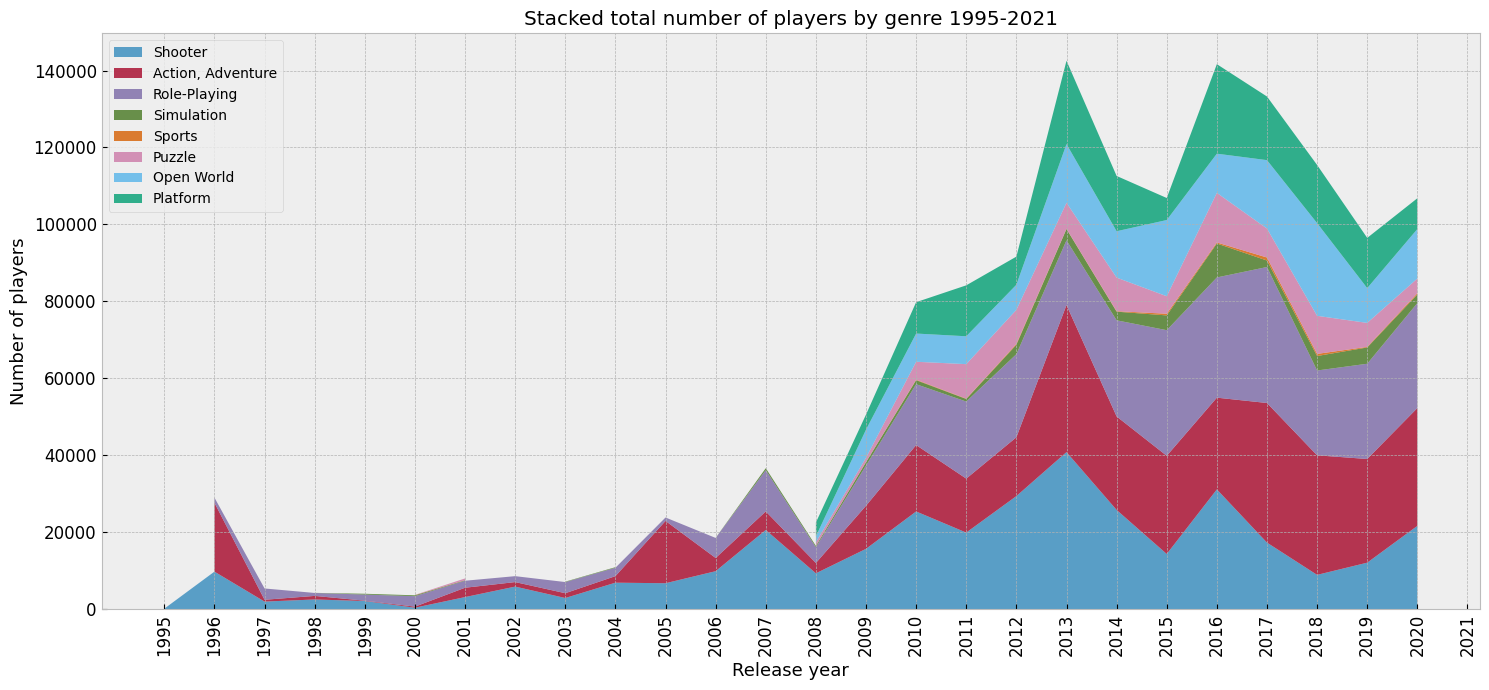

In [56]:
#Genre popularity over time 

# Create the data
data = create_genres_count(table_Polled_full_dates, genre_list, 'Polled_average', 'year', 'sum').loc["1995":"2020"]

# Create the stacked area chart
fig, ax = plt.subplots(figsize=(15, 7), )
ax.stackplot(data.index, data.T.values, labels=data.columns, alpha=0.8,)

# Customize the plot
plt.xticks(np.arange(1995, 2022, 1), rotation=90)
plt.xlabel('Release year', fontsize=13)
plt.title('Stacked total number of players by genre 1995-2021')
plt.ylabel('Number of players', fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=12)

# Add legend
plt.legend(loc='upper left')

# Adjust layout to prevent cutting off labels
plt.tight_layout()
plt.savefig("Stacked total number of players by genre 1995-2021", bbox_inches='tight')

# Show the plot
plt.show()


In [57]:
genre_list = ['Shooter','Action, Adventure','Role-Playing','Simulation','Sports','Puzzle','Open World','Platform']

# Function to highlight max and min values in a row
def highlight_max_min(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return ['background-color: green' if v else 'background-color: red' if m else '' for v, m in zip(is_max, is_min)]

new = create_genres_count(table_Polled_full,genre_list,'Polled_average','platform','sum')
#create_genres_count(table_Polled_full,genre_list,'Polled_average','platform','sum').style.background_gradient(cmap="RdYlGn", axis=1)
new.fillna(0).astype(int)
new.style.apply(highlight_max_min, axis=1).format("{:.0f}")
#new.to_excel("Nb of polled players per platform per genre.xlsx", index=True)

,Shooter,"Action, Adventure",Role-Playing,Simulation,Sports,Puzzle,Open World,Platform
platform,,,,,,,,
Nintendo 3DS,602,7895,19859,900,217,4047,270,5751
Nintendo Switch,2892,22399,38504,2308,1211,4754,9821,29523
PC,210238,150558,179930,23290,1237,78507,81379,98053
PlayStation 3,25259,24184,15096,1372,73,2194,7898,10782
PlayStation 4,48434,77980,59288,8388,582,7167,38017,23561
PlayStation 5,7071,18908,10582,492,48,2678,11328,6811
Wii U,842,3877,1440,nan,24,717,1803,4367
Xbox 360,20908,8928,9632,277,175,1066,5874,3077
Xbox One,16644,12053,8963,523,116,3471,8173,6060


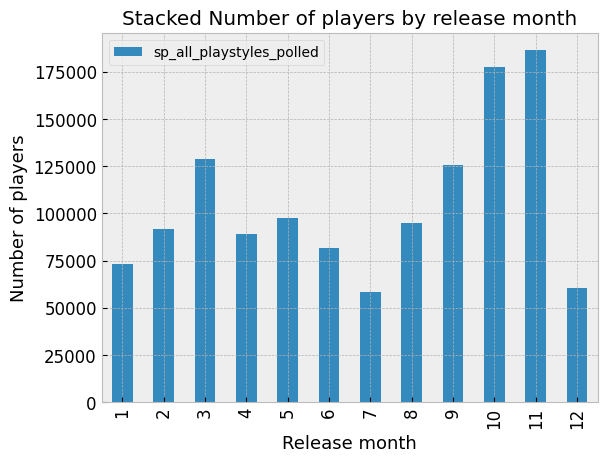

In [58]:
#Creating a table for sp_games with platforms and a month index
new = sp_games[['name','sp_all_playstyles_polled','release_date','Genre']].merge(games_table[['name','platform']], how='left',on='name').dropna(subset='platform').dropna(subset='release_date')

new["month"] = new['release_date'].dt.month
# new['month'] = pd.to_datetime(new['month'], format='%m').dt.month_name().str[:3]
new = new.set_index('release_date').drop_duplicates(subset='name')
new.groupby(['month'])[['sp_all_playstyles_polled']].sum().plot.bar()

plt.xlabel('Release month', fontsize=13)
plt.ylabel('Number of players', fontsize=13)
plt.title('Stacked Number of players by release month')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("Stacked number of players vs release month", bbox_inches='tight')
plt.show()

In [59]:
#March month seems very compared to the rest of the year, is that an outlier or did the switch release had an impact ?
(new
 .query('month == 3')
 .groupby(['platform'],observed=False)[['sp_all_playstyles_polled']]
 .sum()
 .sort_values(by='sp_all_playstyles_polled',ascending=False)
 .head(10))



,sp_all_playstyles_polled
platform,
PC,32046.0
Switch,20079.0
PlayStation 4,14190.0
Xbox One,13267.0
PlayStation 3,13057.0
PlayStation,11288.0
Xbox 360,7570.0
PlayStation 2,4503.0
3DS,2677.0


In [63]:
#Okay, the switch released in march, but when did the most played switch game released ? 3 of the most played released in march
new['platform']= new['platform'].astype('string')
(new[(new['month'] == 3)]
 .sort_values(by='sp_all_playstyles_polled', ascending=False)
 .drop_duplicates(subset='name')
 .head(10))



,name,sp_all_playstyles_polled,Genre,platform,month
release_date,,,,,
2013-03-05,Tomb Raider,9000.0,"Action, Adventure, Platform, Shooter",PlayStation,3
2017-03-03,The Legend of Zelda: Breath of the Wild,7800.0,"Action, Adventure, Open World",Switch,3
2013-03-25,BioShock Infinite,6800.0,"Action, Shooter",PlayStation 3,3
2016-03-11,Ori and the Blind Forest: Definitive Edition,4000.0,Platform,Switch,3
2015-03-12,Yakuza 0,3400.0,"Action, Adventure",Xbox One,3
2014-03-04,South Park: The Stick of Truth,3200.0,Role-Playing,PC,3
2019-03-22,Sekiro: Shadows Die Twice,2800.0,"Action, Adventure",Xbox One,3
2012-03-13,Journey,2700.0,Adventure,PlayStation 4,3
2015-03-24,Bloodborne,2700.0,"Action, Role-Playing",PlayStation 4,3


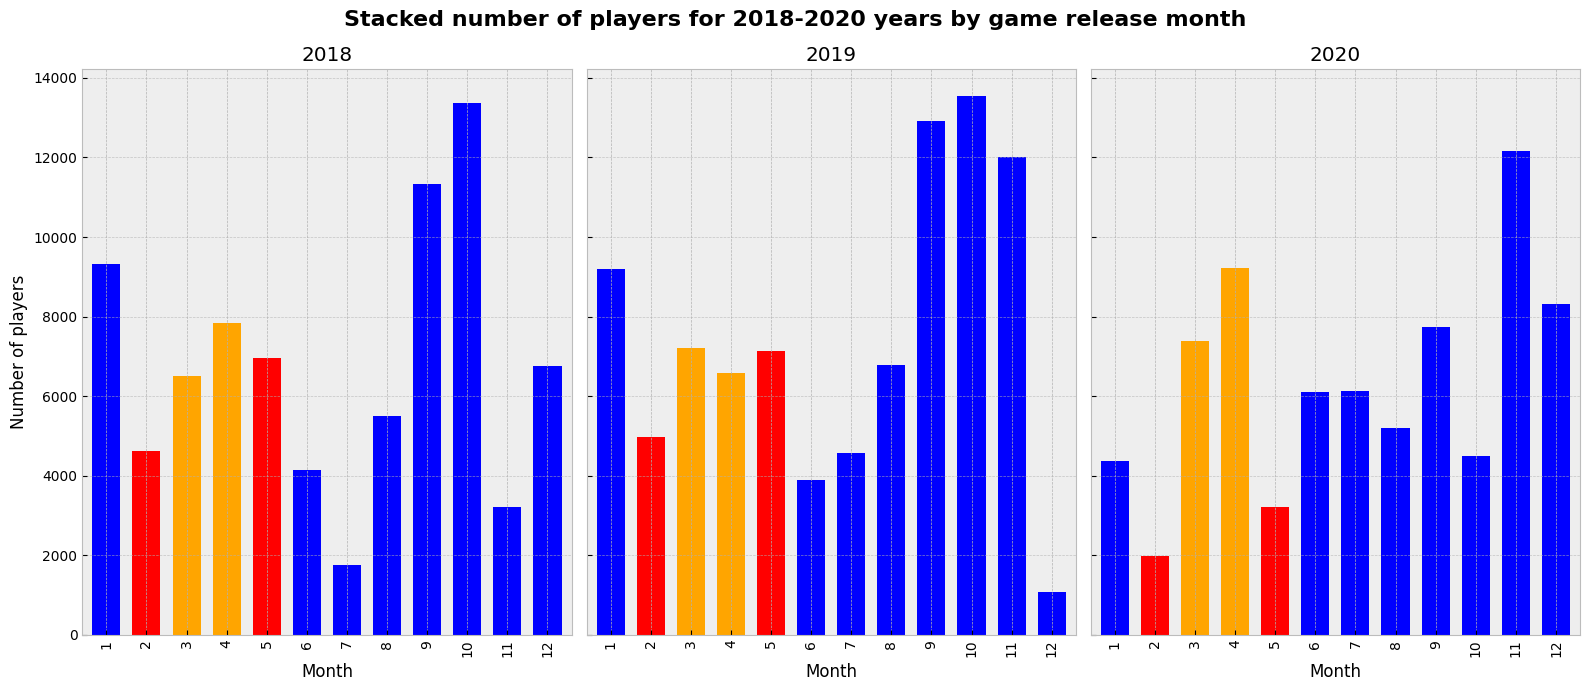

In [66]:
#Comparing number of players vs release dates for 2018 to 2020 year to see COVID impact 

# Create three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 7), sharey=True)

# Function to customize bar colors for months 3 and 4
def color_bars(ax, data):
    colors = ['orange' if month in [3, 4] 
              else 'red' if month in [2, 5] 
              else 'blue' for month in data.index] 
    data.plot.bar(ax=ax, color=colors, width=0.7)

# Plot 2019 data
data_2019 = new.loc["2018"].groupby(['month'])[['sp_all_playstyles_polled']].sum()
color_bars(ax1, data_2019['sp_all_playstyles_polled'])
ax1.set_title('2018')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of players')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2020 data
data_2020 = new.loc["2019"].groupby(['month'])[['sp_all_playstyles_polled']].sum()
color_bars(ax2, data_2020['sp_all_playstyles_polled'])
ax2.set_title('2019')
ax2.set_xlabel('Month')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2021 data
data_2021 = new.loc["2020"].groupby(['month'])[['sp_all_playstyles_polled']].sum()
color_bars(ax3, data_2021['sp_all_playstyles_polled'])
ax3.set_title('2020')
ax3.set_xlabel('Month')
ax3.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
fig.suptitle('Stacked number of players for 2018-2020 years by game release month', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("Stacked number of players for 2018-2020 years by game release month", bbox_inches='tight')
plt.show()




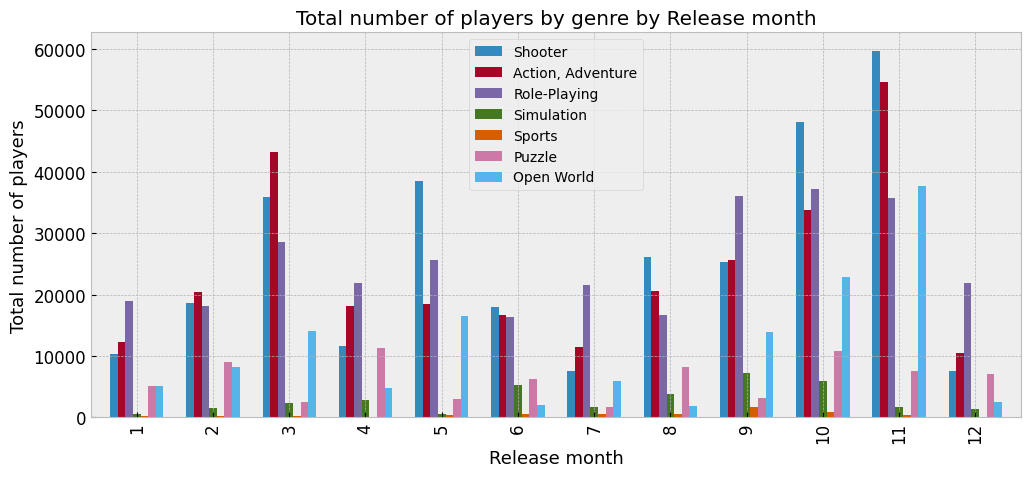

In [67]:

genre_list = ['Shooter','Action, Adventure','Role-Playing','Simulation','Sports','Puzzle','Open World']
create_genres_count(new,genre_list,'sp_all_playstyles_polled','month','sum').plot.bar(figsize=(12,5), width=0.7)

plt.xlabel('Release month', fontsize=13)
plt.ylabel('Total number of players', fontsize=13)
plt.title('Total number of players by genre by Release month')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("Total number of players by genre vs Release month", bbox_inches='tight')
plt.show()

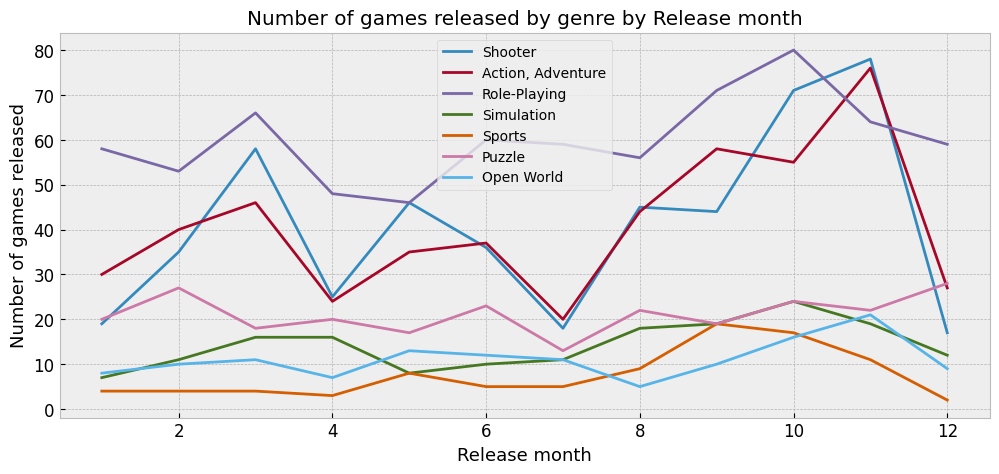

In [68]:
genre_list = ['Shooter','Action, Adventure','Role-Playing','Simulation','Sports','Puzzle','Open World']
create_genres_count(new,genre_list,'name','month','count').plot(figsize=(12,5))

plt.xlabel('Release month', fontsize=13)
plt.ylabel('Number of games released', fontsize=13)
plt.title('Number of games released by genre by Release month')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("Number of games released by genre vs Release month", bbox_inches='tight')
plt.show()

In [70]:
compared_polled = table_Polled_full_dates.loc[2012].groupby(['platform'])[['Polled_average']].sum()
compared_polled.rename(columns={'Polled_average':'2012'},inplace=True)

compared_polled["2013"] = table_Polled_full_dates.loc[2013].groupby(['platform'])[['Polled_average']].sum()
compared_polled["2014"] = table_Polled_full_dates.loc[2014].groupby(['platform'])[['Polled_average']].sum()
compared_polled["2015"] = table_Polled_full_dates.loc[2015].groupby(['platform'])[['Polled_average']].sum()
compared_polled["2016"] = table_Polled_full_dates.loc[2016].groupby(['platform'])[['Polled_average']].sum()
compared_polled["2017"] = table_Polled_full_dates.loc[2017].groupby(['platform'])[['Polled_average']].sum()
compared_polled["2018"] = table_Polled_full_dates.loc[2018].groupby(['platform'])[['Polled_average']].sum()
compared_polled["2019"] = table_Polled_full_dates.loc[2019].groupby(['platform'])[['Polled_average']].sum()
compared_polled["2020"] = table_Polled_full_dates.loc[2020].groupby(['platform'])[['Polled_average']].sum()
compared_polled["2021"] = table_Polled_full_dates.loc[2021].groupby(['platform'])[['Polled_average']].sum()

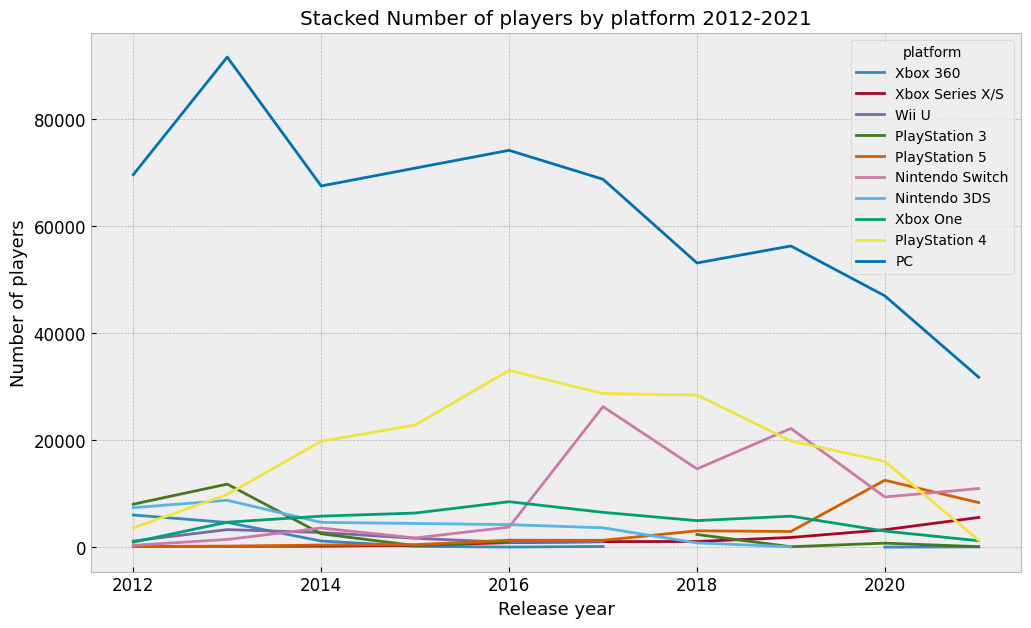

In [71]:
compared_polled.sort_values(by='2016',ascending=True).T.plot(figsize=(12,7))

plt.xlabel('Release year', fontsize=13)
plt.ylabel('Number of players', fontsize=13)
plt.title('Stacked Number of players by platform 2012-2021')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [74]:
# sp_games_rating = sp_games.merge(games_opencritic[['name','opencritic_classification','score']], how='left',on='name').dropna(subset='opencritic_classification')

In [75]:
# (sp_games_rating
#  .groupby(['opencritic_classification'],observed=False)
#  .agg({"sp_main_story_average":'mean',
#        "sp_main_+_extras_average":"mean",
#        "sp_completionist_average":"mean"
#       })).sort_values(by='sp_completionist_average',ascending=False).plot.bar()

# plt.xlabel('Classification', fontsize=13)
# plt.ylabel('Completion time', fontsize=13)
# plt.title('Completion time vs Classification')
# plt.tick_params(axis='both', which='major', labelsize=12)
# plt.show()

In [76]:
# (sp_games_rating
#  .groupby(['opencritic_classification'],observed=False)
#  .agg({"sp_main_story_average":'mean',
#        "sp_main_+_extras_average":"mean",
#        "sp_completionist_average":"mean"
#       })).sort_values(by='sp_completionist_average',ascending=False).pct_change(axis=0)*100

In [77]:
# (sp_games_rating
#  .groupby(['opencritic_classification'],observed=False)
#  .agg({"sp_all_playstyles_polled":"sum"
#       })).sort_values(by='sp_all_playstyles_polled',ascending=False).plot.bar()

# plt.xlabel('Classification', fontsize=13)
# plt.ylabel('Total number of players', fontsize=13)
# plt.title('Stacked Number of players for each game classification')
# plt.tick_params(axis='both', which='major', labelsize=12)
# plt.show()

In [78]:
#But is there a sweetspot for game length in terms of number of players ?

In [79]:
# (sp_games_rating
#  .groupby(['opencritic_classification'],observed=False)
#  .agg({"sp_all_playstyles_polled":"sum"
#       })).sort_values(by='sp_all_playstyles_polled',ascending=False).pct_change()*100

In [80]:
#  (sp_games_rating
#  .groupby(['opencritic_classification'],observed=False)
#  .agg({"score":'mean',
#       })).sort_values(by='score',ascending=False).plot.bar()

# plt.xlabel('Classification', fontsize=13)
# plt.ylabel('Average score', fontsize=13)
# plt.title('Average score for each game classification')
# plt.tick_params(axis='both', which='major', labelsize=12)
# plt.show()

In [81]:
# n3ds_games_rating = n3ds_games.merge(games_opencritic[['name','opencritic_classification','score']], how='left',on='name').dropna(subset='opencritic_classification')

In [82]:
# (n3ds_games_rating
#  .groupby(['opencritic_classification'],observed=False)
#  .agg({"Nintendo 3DS_Main":'mean',
#        "Nintendo 3DS_Main +":"mean",
#        "Nintendo 3DS_100%":"mean"
#       })).sort_values(by='Nintendo 3DS_100%',ascending=False).plot.bar()

In [83]:
# (n3ds_games_rating
#  .groupby(['opencritic_classification'],observed=False)
#  .agg({"Nintendo 3DS_Main":'mean',
#        "Nintendo 3DS_Main +":"mean",
#        "Nintendo 3DS_100%":"mean"
#       })).sort_values(by='Nintendo 3DS_100%',ascending=False).pct_change()

In [84]:
new = sp_games.groupby(['name'])[['sp_all_playstyles_polled']].sum().sort_values(by='sp_all_playstyles_polled',ascending=False).head(10)
new.merge(games_table[['name','Genre']], how='left', on='name').drop_duplicates(subset='name')

,name,sp_all_playstyles_polled,Genre
0,The Witcher 3: Wild Hunt,9500.0,"Action, Open World, Role-Playing"
3,Tomb Raider,9000.0,"Action, Adventure, Platform, Shooter"
11,The Legend of Zelda: Breath of the Wild,7800.0,"Action, Adventure, Open World"
13,Portal,7700.0,"Platform, Puzzle"
14,BioShock Infinite,6800.0,"Action, Shooter"
17,Portal 2,6200.0,"Platform, Puzzle"
20,Persona 5,6000.0,"Role-Playing, Simulation"
21,God of War,5900.0,"Action, Adventure, Hack and Slash"
25,Grand Theft Auto V,5800.0,"Action, Open World, Racing/Driving, Shooter"
30,BioShock,5600.0,"Action, Horror, Shooter"
